<a href="https://colab.research.google.com/github/SamuelTelesSilva/toxic_comment_detection/blob/main/notebooks/classifica%C3%A7%C3%A3o_de_texto_bin%C3%A1ria/2_treinando_bert_binario_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalação

In [ ]:
!pip install tensorflow
!pip install transformers
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.8 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 6.6 MB 78.9 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns

import numpy as np
import tensorflow
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import scikitplot as skplt

from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

#Usando BERT para classificação de texto

treinando um classificador de texto binário com BERT, keras e huggingface.

##Dataset

**Limpeza dos Dados**


coluna text_norm contém:
  - Separação palavras juntas
  - Corrigindo palavras incorretas com a biblioteca **enelvo**
  - retirando emojis com a biblioteca **emoji**
  - foi retirado as pontuações com **string.punctuation**
  - retirado as palavras vazias com **nltk.corpus.stopwords.words('portuguese')**
  - capitalização das palavras deixando tudo em caixa-baixa
  - colab com a normalização dos dados: https://colab.research.google.com/drive/1dHZXclbrZ9WsPCgHoVcMv0gmF2PgnUw-?usp=sharing

In [ ]:
PATH = "/content/drive/MyDrive/Pós-Graduação/Projeto de IA com Aprendizagem de Máquina/dataset/told_df_6.csv"

In [ ]:
told_br = pd.read_csv(PATH)

In [ ]:
#removendo a coluna unnamed
told_br.drop(told_br.columns[told_br.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [ ]:
told_br.head()

,text,text_norm,homophobia,obscene,insult,racism,misogyny,xenophobia,label,toxic
0,Meu nivel de amizade com isis é ela ter meu in...,nível amizade isis ter insta ter penso manda m...,0.0,0.0,2.0,0.0,0.0,0.0,Insult,1
1,"rt @user @user o cara adultera dados, que fora...",cara adultera dados desmascarados ainda quer f...,0.0,0.0,1.0,0.0,0.0,0.0,Insult,1
2,@user @user @user o cara só é simplesmente o m...,cara simplesmente maior vencedor história fute...,0.0,2.0,1.0,0.0,0.0,0.0,Obscene,1
3,eu to chorando vei vsf e eu nem staneio izone ...,to chorando velho vá foder enalteço ozone nada,0.0,1.0,0.0,0.0,0.0,0.0,Obscene,1
4,Eleitor do Bolsonaro é tão ignorante q não per...,eleitor bolsonaro tão ignorante percebeu frase...,0.0,1.0,2.0,0.0,0.0,0.0,Insult,1


In [ ]:
#alterando o tipo da coluna text_norm
told_br['text_norm'] = told_br['text_norm'].astype(str)

In [ ]:
told_br.shape

(21000, 10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


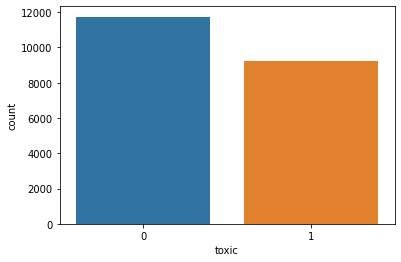

In [ ]:
sns.countplot(told_br['toxic']);

In [ ]:
np.unique(told_br['toxic'], return_counts=True)

(array([0, 1]), array([11745,  9255]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


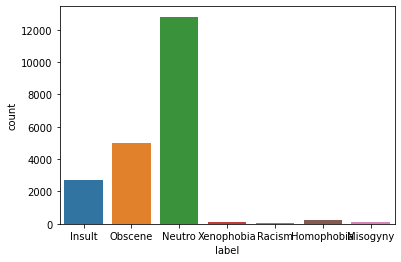

In [ ]:
sns.countplot(told_br['label']);

In [ ]:
np.unique(told_br['label'], return_counts=True)

(array(['Homophobia', 'Insult', 'Misogyny', 'Neutro', 'Obscene', 'Racism',
        'Xenophobia'], dtype=object),
 array([  207,  2730,    95, 12812,  5017,    54,    85]))

deixando apenas 5000 comentarios para fazer os testes

In [ ]:
told_br = told_br[0:5000]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


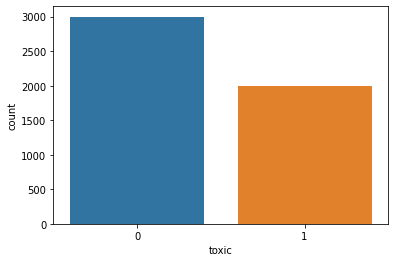

In [ ]:
sns.countplot(told_br['toxic']);

##Classificação de texto

In [ ]:
#Pegando os comentarios do dataset ja normalizados
sentences = told_br['text_norm']

#pegando as labels 0 e 1 do dataet
labels = told_br['toxic']

len(sentences),len(labels)

(5000, 5000)

Modelo BERT pré-treinado para o português do Brasil

https://huggingface.co/neuralmind/bert-base-portuguese-cased

In [ ]:
#transformers do huggingface
from transformers import BertTokenizer, TFBertModel

bert_tokenizer =\
BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

bmodel = TFBertModel.from_pretrained("neuralmind/bert-base-portuguese-cased", from_pt=True)

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
input_ids = []

for sent in sentences:
   bert_inp = bert_tokenizer.encode_plus(
       sent,
       add_special_tokens = True,
       max_length = 64,
       pad_to_max_length = True,
       return_attention_mask = True)
   
   input_ids.append(bert_inp['input_ids'])

input_ids = np.asarray(input_ids)
labels = np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids

array([[  101,  2270,  8286, ...,     0,     0,     0],
       [  101,  1354,  4183, ...,     0,     0,     0],
       [  101,  1354,  4877, ...,     0,     0,     0],
       ...,
       [  101,   240,   124, ...,     0,     0,     0],
       [  101,  5231, 22283, ...,     0,     0,     0],
       [  101,   240,   124, ...,     0,     0,     0]])

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([2999, 2001]))

##Sobreamostragem (oversampling) - SMOTE

Class=1, n=2999 (50.000%)
Class=0, n=2999 (50.000%)


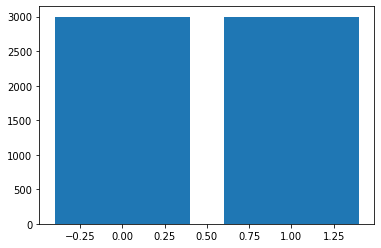

In [ ]:
# Encode do label
label_encode = LabelEncoder()
yz = label_encode.fit_transform(labels)

# transformando o dataset
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(input_ids, yz)

#distribuição
counter = Counter(y_over)
for k,v in counter.items():
	per = v / len(y_over) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
# plot distribuição
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([2999, 2001]))

In [ ]:
np.unique(y_over, return_counts=True)

(array([0, 1]), array([2999, 2999]))

##Base de treinamento e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_treinamento_oo, X_teste_oo, y_treinamento_oo, y_teste_oo = train_test_split(X_over, y_over, 
                                                                          test_size = 0.2, stratify = y_over)


In [ ]:
X_treinamento_oo.shape, X_teste_oo.shape

((4798, 64), (1200, 64))

##Random Forest - Oversampling

In [ ]:
modelo_o = RandomForestClassifier()
modelo_o.fit(X_treinamento_oo, y_treinamento_oo)
previsoes_o = modelo_o.predict(X_teste_oo)
accuracy_score(previsoes_o, y_teste_oo)

0.6958333333333333

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7009    0.6833    0.6920       600
           1     0.6911    0.7083    0.6996       600

    accuracy                         0.6958      1200
   macro avg     0.6960    0.6958    0.6958      1200
weighted avg     0.6960    0.6958    0.6958      1200

Acurácia: 0.6958



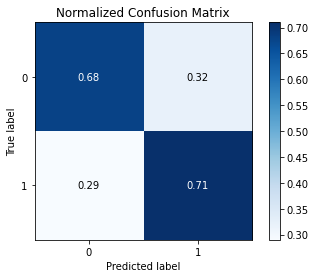

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_o, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_o, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_o)))

##Naive Bayes Classifier - Oversampling

In [ ]:
modelo_multi_NB_O = MultinomialNB()
modelo_multi_NB_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_NB_O = modelo_multi_NB_O.predict(X_teste_oo)
accuracy_score(previsoes_NB_O, y_teste_oo)

0.535

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5253    0.7267    0.6098       600
           1     0.5568    0.3433    0.4247       600

    accuracy                         0.5350      1200
   macro avg     0.5410    0.5350    0.5173      1200
weighted avg     0.5410    0.5350    0.5173      1200

Acurácia: 0.5350



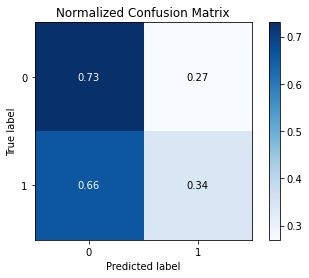

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_NB_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_NB_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_NB_O)))

##Support Vector Machine (SVM) - Oversampling

In [ ]:
modelo_SVC_O = SVC()
modelo_SVC_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_SVC_O = modelo_SVC_O.predict(X_teste_oo)
accuracy_score(previsoes_SVC_O, y_teste_oo)

0.5708333333333333

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5739    0.5500    0.5617       600
           1     0.5680    0.5917    0.5796       600

    accuracy                         0.5708      1200
   macro avg     0.5710    0.5708    0.5706      1200
weighted avg     0.5710    0.5708    0.5706      1200

Acurácia: 0.5708



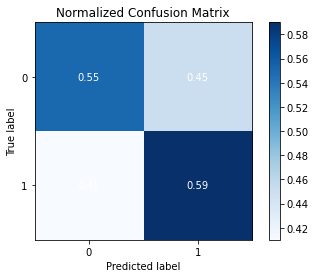

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_SVC_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_SVC_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_SVC_O)))

##Logistic Regression - Oversampling

In [ ]:
modelo_RL_O = LogisticRegression()
modelo_RL_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_RL_O = modelo_RL_O.predict(X_teste_oo)
accuracy_score(previsoes_RL_O, y_teste_oo)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5341666666666667

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5319    0.5700    0.5503       600
           1     0.5368    0.4983    0.5169       600

    accuracy                         0.5342      1200
   macro avg     0.5343    0.5342    0.5336      1200
weighted avg     0.5343    0.5342    0.5336      1200

Acurácia: 0.5342



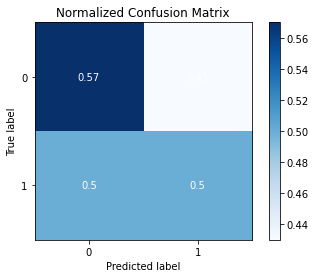

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_RL_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_RL_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_RL_O)))

##Gradient Boosting - Oversampling

In [ ]:
modelo_GB_O = GradientBoostingClassifier()
modelo_GB_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_GB_O = modelo_GB_O.predict(X_teste_oo)
accuracy_score(previsoes_GB_O, y_teste_oo)

0.635

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6397    0.6183    0.6288       600
           1     0.6306    0.6517    0.6410       600

    accuracy                         0.6350      1200
   macro avg     0.6352    0.6350    0.6349      1200
weighted avg     0.6352    0.6350    0.6349      1200

Acurácia: 0.6350



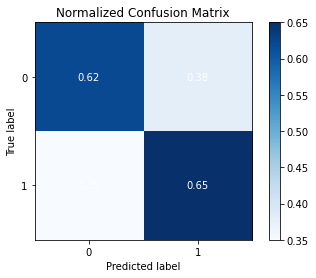

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_GB_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_GB_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_GB_O)))